**Final Project Submission**

Please fill out:

* Student name: Nadine Amersi-Belton
* Student pace: part time
* Scheduled project review date/time: 18/09/20 at 4:00pm BST
* Instructor name: Victor Geislinger
* Blog post URL: https://medium.com/@nadinezab/the-importance-of-domain-knowledge-40d57ae0a91b?sk=f497c9c330990f784de5509ad1cc8460

# Chest X-ray Pneumonia Detection

This project was completed as part of Flatiron School's Data Science Bootcamp (Module 4 Final Project).

## Introduction

### Problem Statement

This project was completed in September 2020, during the worldwide COVID-19 pandemic. To help diagnose patients chest X-rays are examined. Machine learning presents an opportunity to expediate diagnosis and prevent human errors.

Due to insufficient data pertaining to COVID-19 patients, we have chosen to apply machine learning tools, in particular deep neural networks, to pneumonia x-ray images.

### Methodology

We will adopt the OSEMN data science workflow, which involves:

1. Obtain (import the data)
2. Scrub (clean the data, deal with missing values and data types)
3. Explore (answer descriptives questions using EDA)
4. Model (build our predictive model)
5. iNterpret (comment on our model and findings)

### Libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
import shutil
import pickle

import math 
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

import itertools

# Set random seed for reproducability
np.random.seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Obtain Data

The dataset was obtained from <a href = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'> Kaggle</a>. Due to the large file size, the data was not saved in this repository.

There are three folders, `train`, `test` and `val` and each has both normal x-ray images (from healthy individuals) and pneumonia x-ray images (from patients who have been diagnosed as having pneumonia).

### Load data

Let us begin by loading the data and examining the number of images in each folder.

In [12]:
# Set file paths
pneumonia_test = '../Data/chest-xray/test/PNEUMONIA'
normal_test = '../Data/chest-xray/test/NORMAL'
pneumonia_train = '../Data/chest-xray/train/PNEUMONIA'
normal_train = '../Data/chest-xray/train/NORMAL'
pneumonia_val = '../Data/chest-xray/val/PNEUMONIA'
normal_val = '../Data/chest-xray/val/NORMAL'

# List of folders
folders = [pneumonia_test, normal_test, pneumonia_train,
                normal_train, pneumonia_val, normal_val]

# Check split amongst training, test and validation
folder_size = [print(f'There are {len(os.listdir(i))} images in the {i} set')\
               for i in folders]

There are 390 images in the ../Data/chest-xray/test/PNEUMONIA set
There are 234 images in the ../Data/chest-xray/test/NORMAL set
There are 3475 images in the ../Data/chest-xray/train/PNEUMONIA set
There are 1201 images in the ../Data/chest-xray/train/NORMAL set
There are 408 images in the ../Data/chest-xray/val/PNEUMONIA set
There are 148 images in the ../Data/chest-xray/val/NORMAL set


In [13]:
# Look at percentage split of train/test/validation sets
test_size = len(os.listdir(pneumonia_test))+len(os.listdir(normal_test))
train_size = len(os.listdir(pneumonia_train))+len(os.listdir(normal_train))
val_size = len(os.listdir(pneumonia_val))+len(os.listdir(normal_val))
total_size = train_size + test_size + val_size
print(f"Train set size: {round(train_size/total_size*100,2)}%")
print(f"Test set size: {round(test_size/total_size*100,2)}%")
print(f"Validation set size: {round(val_size/total_size*100,2)}%")

Train set size: 79.85%
Test set size: 10.66%
Validation set size: 9.49%


We would prefer a split closer to 80% training, 10% test and 10% validation. As such our next step is to move images around to achieve this ratio.

### Split data

We have elected to move roughly 10% of the training set into validation set in order to meet our desired split.

In [14]:
# creating list of files in training set to be moved
pneumonia_train_imgs = [file for file in os.listdir(pneumonia_train)]
normal_train_imgs = [file for file in os.listdir(normal_train)]

In [15]:
# Increase size of pneumonia val set
imgs = pneumonia_train_imgs[-400:]
for img in imgs:
    origin = os.path.join(pneumonia_train, img)
    destination = pneumonia_val
    shutil.move(origin, destination)

In [16]:
# Increase size of normal val set
imgs = normal_train_imgs[-140:]
for img in imgs:
    origin = os.path.join(normal_train, img)
    destination = normal_val
    shutil.move(origin, destination)

In [17]:
# Get train/test/validation set sizes as a percentage
test_size = len(os.listdir(pneumonia_test))+len(os.listdir(normal_test))
train_size = len(os.listdir(pneumonia_train))+len(os.listdir(normal_train))
val_size = len(os.listdir(pneumonia_val))+len(os.listdir(normal_val))
total_size = train_size + test_size + val_size
print(f"Train set size: {round(train_size/total_size*100,2)}%")
print(f"Test set size: {round(test_size/total_size*100,2)}%")
print(f"Validation set size: {round(val_size/total_size*100,2)}%")

Train set size: 79.85%
Test set size: 10.66%
Validation set size: 9.49%


We are now satisfied with our train/ test/ validation split.

### Visualize images

Before pre-processing, let us have a look at sample images for both normal and pneumonia x-rays.

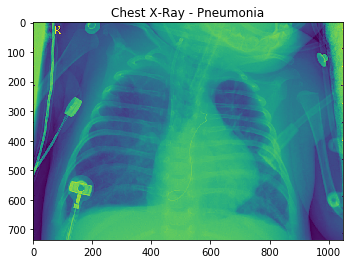

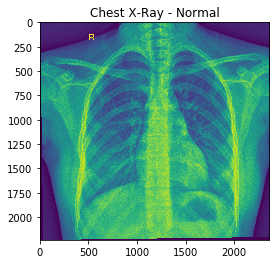

In [15]:
sample_pneumonia_img = mpimg.imread(os.path.join(pneumonia_train, pneumonia_train_imgs[0]))
sample_normal_img = mpimg.imread(os.path.join(normal_train, normal_train_imgs[0]))

imgplot = plt.imshow(sample_pneumonia_img)
plt.title('Chest X-Ray - Pneumonia')
plt.show()
imgplot = plt.imshow(sample_normal_img)
plt.title('Chest X-Ray - Normal')
plt.show()

As we can see, for the untrained human eye, it is particularly hard to spot the differences and make a diagnosis. 

## Data preprocessing

We will resize all the images to be of the same size, namely 100x100. Unfortunately this means we will change the aspect ratio as we see from the above sample images that the images are not all square-shaped.

We will also rescale the images by dividing by 255 to obtain grayscale images.

In [16]:
# Define location paths
train_set = '../Data/chest-xray/train'
test_set = '../Data/chest-xray/test'
val_set = '../Data/chest-xray/val'

In [17]:
# Get set sizes
print(f"Train set size: {train_size}")
print(f"Test set size: {test_size}")
print(f"Validation set size: {val_size}")

Train set size: 4676
Test set size: 624
Validation set size: 556


In [18]:
# Get training data, resize and rescale
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_set, 
        target_size=(100, 100), batch_size=4676)

# Get test data, resize and rescale
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_set, 
        target_size=(100, 100), batch_size = 624) 

# Get validation data, resize and rescale
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_set, 
        target_size=(100, 100), batch_size = 556)

Found 4676 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


In [19]:
# Create data sets
train_imgs, train_labels = next(train_generator)
test_imgs, test_labels = next(test_generator)
val_imgs, val_labels = next(val_generator)

Let us check the shape of a training sample as well as preview the image.

In [20]:
# Explore our datasets
m_train = train_imgs.shape[0]
num_px = train_imgs.shape[1]
m_test = test_imgs.shape[0]
m_val = val_imgs.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_imgs.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_imgs.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_imgs.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4676
Number of testing samples: 624
Number of validation samples: 556
train_images shape: (4676, 100, 100, 3)
train_labels shape: (4676, 2)
test_images shape: (624, 100, 100, 3)
test_labels shape: (624, 2)
val_images shape: (556, 100, 100, 3)
val_labels shape: (556, 2)


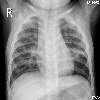

In [26]:
# Preview image
array_to_img(train_imgs[0])

In [27]:
# Reshape images
train_img = train_imgs.reshape(train_imgs.shape[0], -1)
test_img = test_imgs.reshape(test_imgs.shape[0], -1)
val_img = val_imgs.reshape(val_imgs.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4676, 30000)
(624, 30000)
(556, 30000)


In [28]:
# Preview labels
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [29]:
# Check class allocation
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [30]:
# Reshape labels
train_y = np.reshape(train_labels[:,1], (4676,1))
test_y = np.reshape(test_labels[:,1], (624,1))
val_y = np.reshape(val_labels[:,1], (556,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4676, 1)
(624, 1)
(556, 1)


The following preprocessed data files were used to train models on Google Collab. They have been commented out as the file sizes exceed GitHub's allowance.

In [31]:
# # Save preprocessed files

# with open('train_y', 'wb') as fp:
#     pickle.dump(train_y, fp)
    
# with open('val_y', 'wb') as fp:
#     pickle.dump(val_y, fp)

# with open('test_y', 'wb') as fp:
#     pickle.dump(test_y, fp)
    
# with open('train_imgs', 'wb') as fp:
#     pickle.dump(train_imgs, fp)
    
# with open('val_imgs', 'wb') as fp:
#     pickle.dump(val_imgs, fp)

# with open('test_imgs', 'wb') as fp:
#     pickle.dump(test_imgs, fp)

## Explore Data

Before modelling, let us explore our dataset and get a sense of the distribution of pneumonia vs. normal images in the three sets.

In [156]:
# Get set sizes

pneumonia_train_size = sum(train_y)[0]
normal_train_size = len(train_y) - pneumonia_train_size

pneumonia_test_size = sum(test_y)[0]
normal_test_size = len(test_y) - pneumonia_test_size

pneumonia_val_size = sum(val_y)[0]
normal_val_size = len(val_y) - pneumonia_val_size

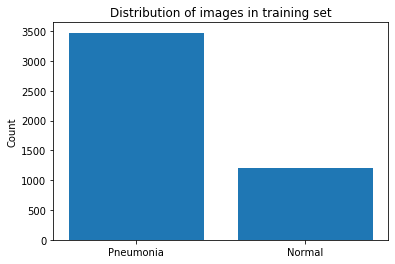

In [157]:
# Plot distribution in training set

xs = ['Pneumonia', 'Normal']
ys = [pneumonia_train_size, normal_train_size]
plt.bar(xs, ys)
plt.title('Distribution of images in training set')
plt.ylabel('Count')
plt.savefig('Images/distribution.pdf', bbox_inches = "tight")
plt.show()

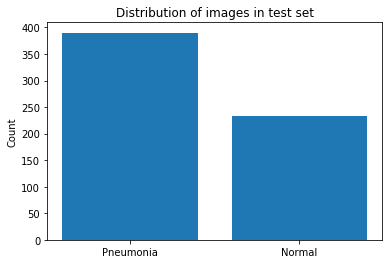

In [172]:
# Plot distribution in test set

xs = ['Pneumonia', 'Normal']
ys = [pneumonia_test_size, normal_test_size]
plt.bar(xs, ys)
plt.title('Distribution of images in test set')
plt.ylabel('Count')
plt.show()

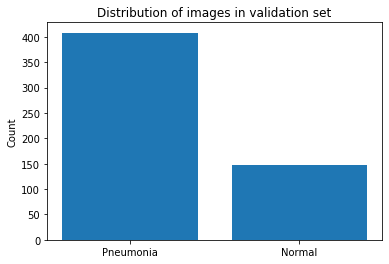

In [173]:
xs = ['Pneumonia', 'Normal']
ys = [pneumonia_val_size, normal_val_size]
plt.title('Distribution of images in validation set')
plt.ylabel('Count')
plt.bar(xs, ys)
plt.show()

## Modelling

### Helper functions

In this section we will define a few functions to help visualise our model's performance.

In [89]:
# Function to plot loss and accuracy
def plot_loss_acc(history):
    ''' Plots training and validation loss and accuracy'''
    plt.figure(figsize=(10,5))
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [90]:
def plot_confusion_matrix(y_true, y_pred):
    '''Plots a confusion matrix'''
    class_names = ['Normal','Pneumonia']

    plt.grid(b=None)
    cmap=plt.cm.Blues  
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.imshow(cnf_matrix, cmap=cmap) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)


    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
    plt.colorbar()
    plt.show()

### Baseline model

For our first baseline model, we will build a deep neural network with two hidden layers. We have chosen a small number of units and kept this model relatively simple.

In [91]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(20, activation='relu', input_shape = (30000,))) 
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='relu'))

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

In [92]:
# Get summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 20)                600020    
_________________________________________________________________
dense_26 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 6         
Total params: 600,551
Trainable params: 600,551
Non-trainable params: 0
_________________________________________________________________


As this is a binary classification problem, the most suitable loss function to use is `binary_crossentropy`. We have chosen `Nadam` as the optimizer as it combines Adam with Nesterov momentum, to maximise speed and likelyhood of convergence.

In [93]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

We will train the model for 100 epochs, using local CPU.

In [94]:
# Fit model set epochs to ensure convergence
history = model.fit(train_img, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_img, val_y))

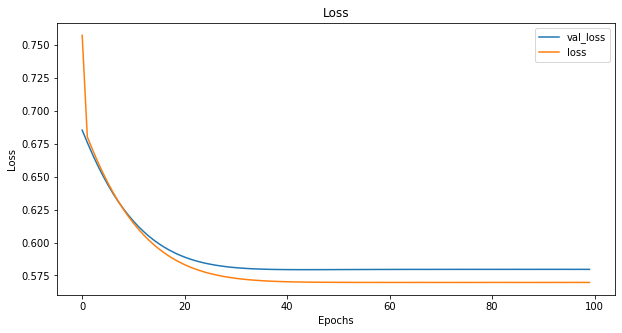

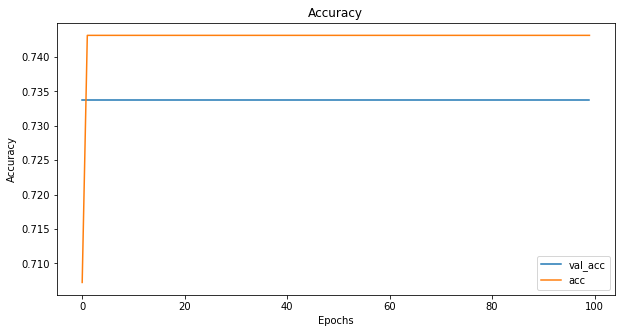

In [95]:
# Visualise loss and accuracy
plot_loss_acc(history)

From the visualisations, we see that there is slight overfitting towards the end, after the 80th epoch the training loss continues to decrease whereas the validation loss stabilizes. Conversely, the training accuracy continues to increase whereas the validation accuracy stabilizes.

In [96]:
y_pred = model.predict(val_img)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.73      1.00      0.85       408

    accuracy                           0.73       556
   macro avg       0.37      0.50      0.42       556
weighted avg       0.54      0.73      0.62       556



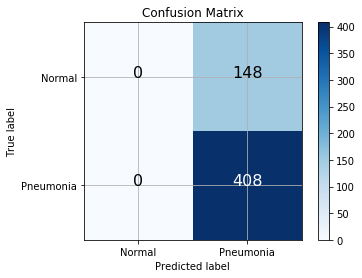

In [97]:
plot_confusion_matrix(val_y, y_pred)

### CNN model

Let us now build a basic CNN model and see how it compares.

In [98]:
# Set path to save model
model_filepath = './Models/best_basic_cnn_model.h5'

# Define stopping criterion
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath=model_filepath, verbose=0, 
                                  monitor='val_loss', save_best_only=True)]

In [99]:
# Build baseline CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [100]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 46, 46, 32)        16416     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)            

In [101]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [102]:
# Fit model
history = model.fit(train_imgs, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_imgs, val_y), callbacks = callbacks)

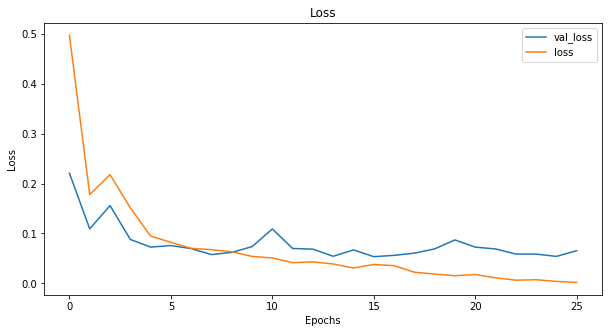

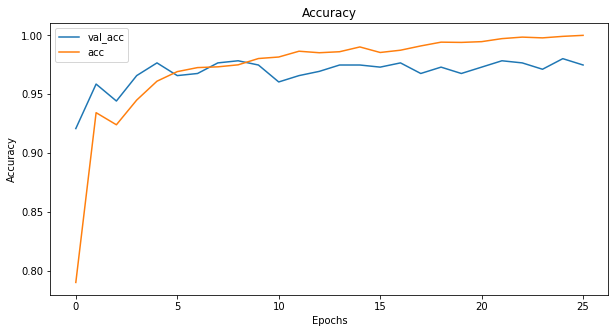

In [103]:
plot_loss_acc(history)

In [104]:
y_pred = model.predict(val_imgs)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       148
           1       0.98      0.99      0.98       408

    accuracy                           0.97       556
   macro avg       0.97      0.96      0.97       556
weighted avg       0.97      0.97      0.97       556



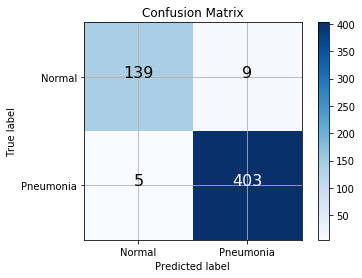

In [105]:
plot_confusion_matrix(val_y, y_pred)

### Visualisation

In [106]:
img_path = '../Data/chest-xray/train/PNEUMONIA/person1_bacteria_1.jpeg'

(1, 100, 100, 3)


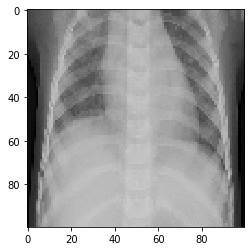

In [107]:
# Assign the first image to a keras image object
img = image.load_img(img_path, target_size=(100, 100))
# Create a tensor of the images pixel values
img_tensor = image.img_to_array(img)
# Alter the dimentionality of the array to that of a tensor
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [108]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [109]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

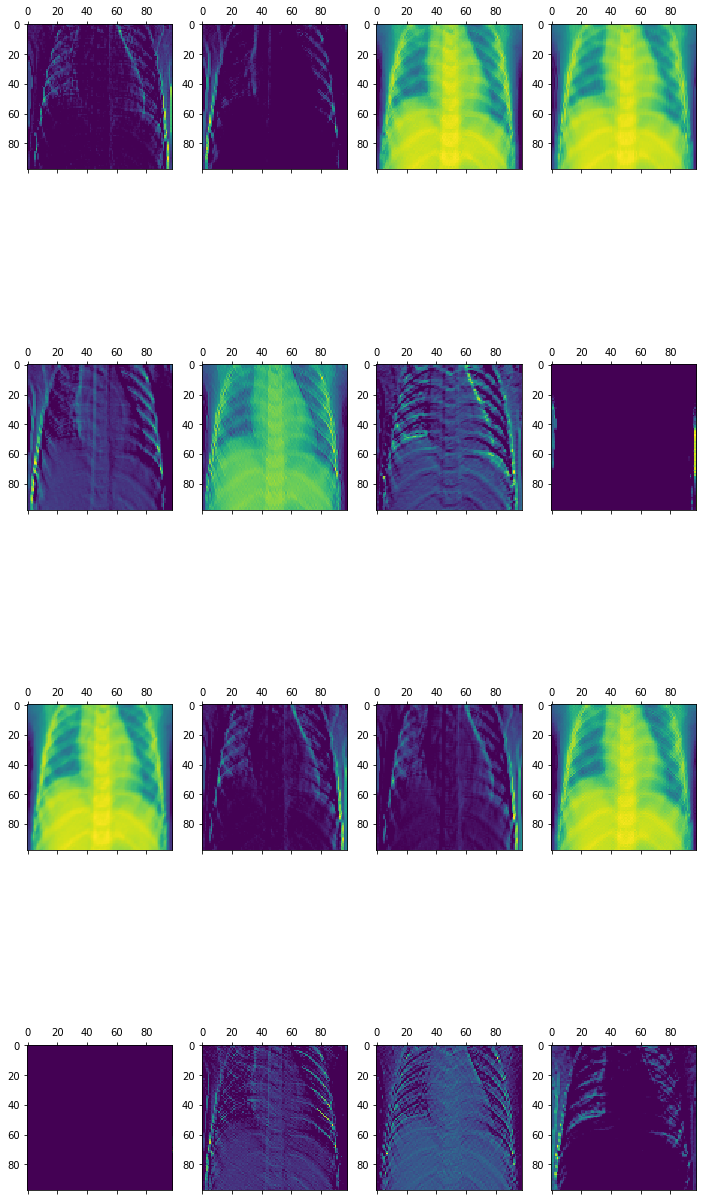

In [110]:
fig, axes = plt.subplots(4, 4, figsize=(12,24))
for i in range(16):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### CNN with dropout

We will now add dropout layers in the hope of getting a more stable model which converges.

In [111]:
# Set path to save model
model_filepath = './Models/best_cnn_with_dropout_model.h5'

# Define stopping criterion
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath=model_filepath, verbose=0, 
                                  monitor='val_loss', save_best_only=True)]

In [112]:
# Build CNN with dropout model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [113]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 46, 46, 32)        16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 21, 21, 64)      

In [114]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [115]:
# Fit model
history = model.fit(train_imgs, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_imgs, val_y), callbacks = callbacks)

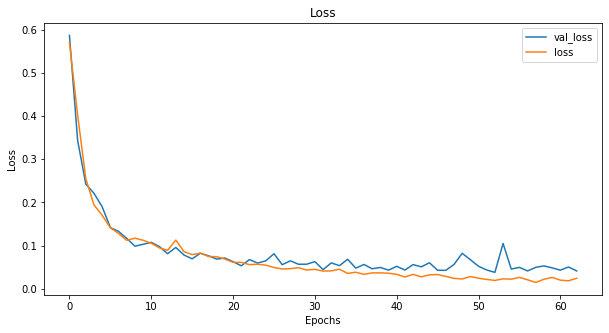

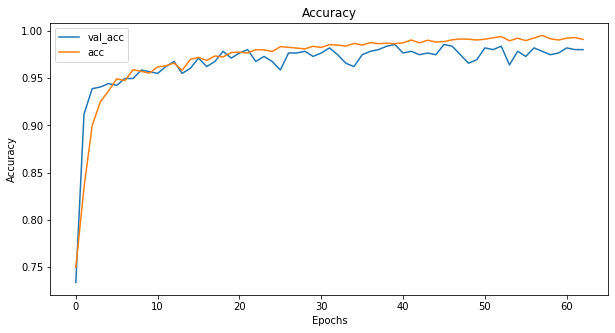

In [117]:
plot_loss_acc(history)

In [118]:
y_pred = model.predict(val_imgs)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       148
           1       0.99      0.98      0.99       408

    accuracy                           0.98       556
   macro avg       0.97      0.98      0.97       556
weighted avg       0.98      0.98      0.98       556



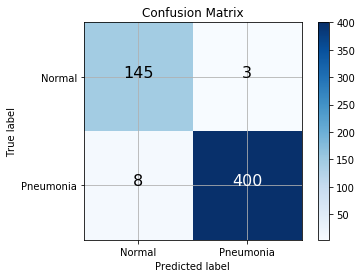

In [119]:
plot_confusion_matrix(val_y, y_pred)

### Further CNN model

In [121]:
# Build CNN with dropout model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                        input_shape=(100,100,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
# Add dropouts to the model
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
# Add dropouts to the model
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid'))

In [122]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)      

In [123]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [124]:
# Set path to save model
model_filepath = './Models/best_cnn_32_64_model.h5'

# Define stopping criterion
callbacks = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath=model_filepath, verbose=0, 
                                  monitor='val_loss', save_best_only=True)]

In [125]:
# Fit model
history = model.fit(train_imgs, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_imgs, val_y), callbacks = callbacks)

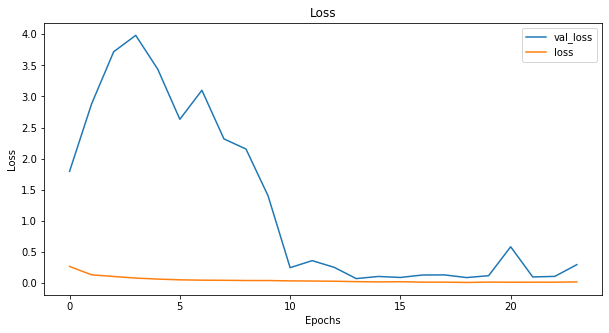

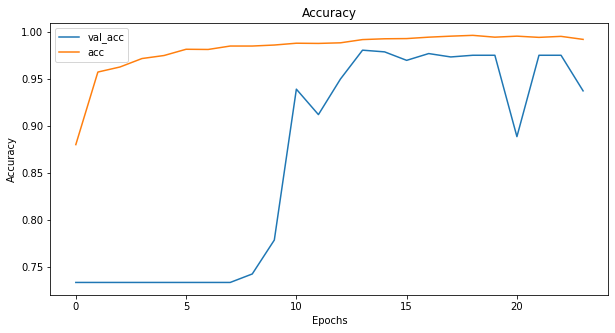

In [126]:
plot_loss_acc(history)

In [127]:
y_pred = model.predict(val_imgs)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.99      0.89       148
           1       0.99      0.92      0.96       408

    accuracy                           0.94       556
   macro avg       0.91      0.95      0.92       556
weighted avg       0.95      0.94      0.94       556



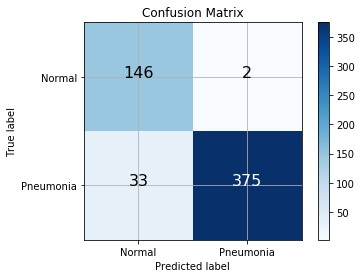

In [128]:
plot_confusion_matrix(val_y, y_pred)

We will now see if by making some small tweaks we can improve convergence.

### CNN model with L2 reg

In [129]:
# Build CNN with dropout model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', 
                        kernel_regularizer='l2', input_shape=(100,100,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',
                        activation='relu', kernel_regularizer='l2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
# Add dropouts to the model
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', 
                        activation='relu', kernel_regularizer='l2'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', 
                        activation='relu', kernel_regularizer='l2'))
# Add dropouts to the model
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid', kernel_regularizer='l2'))

In [130]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 32)      

In [131]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [132]:
# Set path to save model
model_filepath = './Models/best_cnn_32_64_l2_model.h5'

# Define stopping criterion
callbacks = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath=model_filepath, verbose=0, 
                                  monitor='val_loss', save_best_only=True)]

In [133]:
# Fit model
history = model.fit(train_imgs, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_imgs, val_y), callbacks = callbacks)

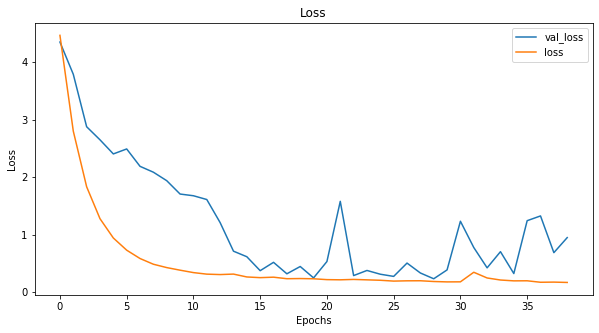

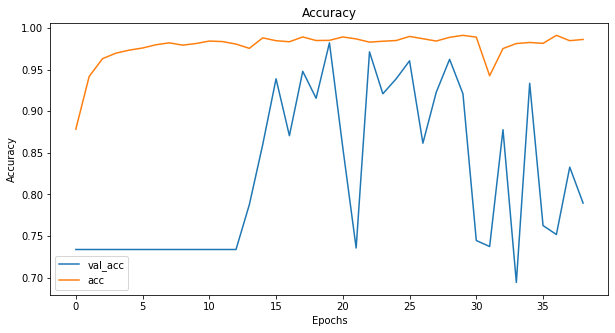

In [134]:
plot_loss_acc(history)

In [135]:
y_pred = model.predict(val_imgs)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.21      0.35       148
           1       0.78      1.00      0.87       408

    accuracy                           0.79       556
   macro avg       0.89      0.60      0.61       556
weighted avg       0.84      0.79      0.73       556



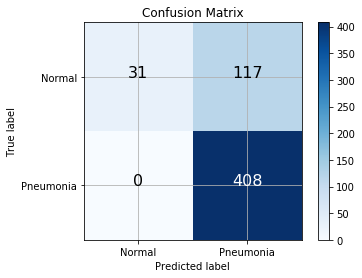

In [136]:
plot_confusion_matrix(val_y, y_pred)

### VGG19

In [137]:
# Instantiate VGG19
modelvgg19 = VGG19(include_top=False,
                   weights='imagenet',
                   input_shape=(100, 100,3))

modelvgg19.trainable = False

# Create VGG19 model
model = models.Sequential()
# Add VGG19
model.add(modelvgg19)
# Add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid', kernel_regularizer='l2'))

In [138]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [139]:
# Set path to save model
model_filepath = './Models/best_vgg19_model.h5'

# Define stopping criterion
callbacks = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath=model_filepath, verbose=0, 
                                  monitor='val_loss', save_best_only=True)]

In [140]:
# Fit model
history = model.fit(train_imgs, train_y, epochs = 100, batch_size = 100, verbose = 0,
                    validation_data = (val_imgs, val_y), callbacks = callbacks)

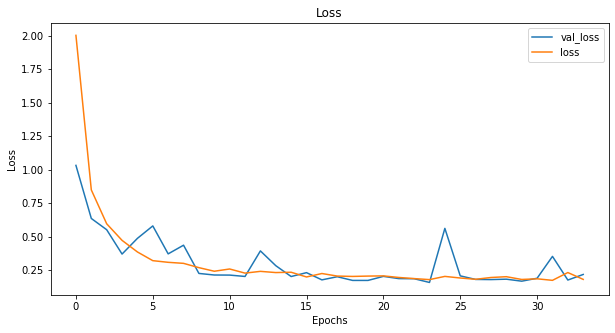

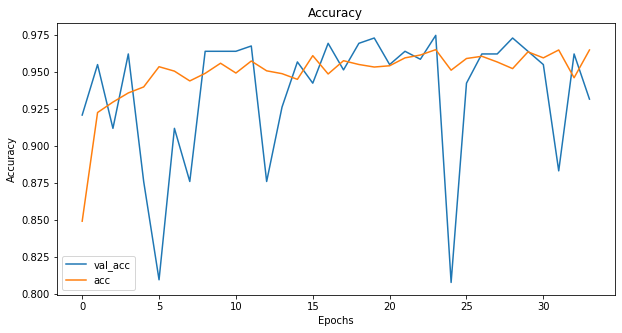

In [141]:
plot_loss_acc(history)

In [142]:
y_pred = model.predict(val_imgs)
y_pred = np.rint(y_pred)
print(classification_report(val_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86       148
           1       0.92      0.99      0.96       408

    accuracy                           0.93       556
   macro avg       0.95      0.88      0.91       556
weighted avg       0.93      0.93      0.93       556



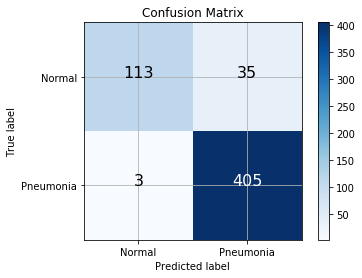

In [143]:
plot_confusion_matrix(val_y, y_pred)

### Evaluate on test set

In [146]:
best_model = load_model('Models/best_cnn_with_dropout_model.h5')

y_pred = best_model.predict(test_imgs)
y_pred = np.rint(y_pred)
print(classification_report(test_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.44      0.60       234
           1       0.75      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.73       624
weighted avg       0.83      0.78      0.76       624



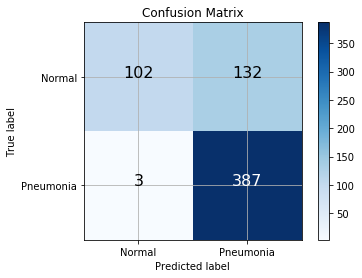

In [160]:
class_names = ['Normal','Pneumonia']

plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(test_y, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment='center',
             fontsize=16,
            color='white' if cnf_matrix[i, j] > thresh else 'black')
plt.colorbar()
plt.savefig('Images/confmatrix.pdf', bbox_inches = "tight")
plt.show()

## Conclusion

### Results and recommendations

The CNN model labelled `best_cnn_with_dropout_model` was chosen as our final model and achieved the following scores when applied to the unseen test set:
* accuracy of 0.78
* recall of 0.99
* F1 score of 0.85

Whilst we would prefer higher accuracy, the model still performs well as it minimizes recall, and thus false negatives. This is particularly important for patient safety and to minimize the legal risk.

We would recommend the following actions:
* gather additional data, this classification was undertaken on a small sample size of around 5k images and served as a proof of concept
* address class imbalance to seek to improve performance using say oversampling techniques
* use this tool to support medical professionals whilst it is further improved on

### Next steps

As future work on this project, I would like to investigate the following:
* **Adjust for class imbalance**. As we saw in the data exploration section, the number of pneumonia vs. normal x-ray images is weighted in favour of those with pneumonia. We could use resampling techniques to achieve a more even split
* **Gather more data**. This dataset had only 5k images, which was sufficient for a proof of concept. Additional data will allow for a more robust model.
* **Data augmentation**. Once we have a clearer idea of how x-ray images can vary, we can use data augmentation tools to generate new data.
* **Apply the model to other x-ray images**. Seek to identify COVID-19 or other illnesses using similar means.